In [34]:
import numpy as np 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import music21
import matplotlib as plt
import torchvision.utils as vutils

import torch.backends.cudnn as cudnn
torch.cuda.empty_cache()
cudnn.benchmark = True  # Optimise for hardware

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [35]:
BATCH_SIZE = 64
EPOCHS = 250
NOISE_DIM= 100
NUM_CLASSES = 18
BETA1 = 0.50 # Hyperparamter for adam optimizer
LRD = 0.0001 # Might need to adjust
LRG = 0.0002
EMBEDDING_DIM = 50
MODEL_PATH = "Model.pt"

In [36]:
"""  
Generator model that accepts a random noise input vector of size 50 and creates an output piano roll of 1x128x256
"""
 
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Embedding for the labels
        self.label_emb = nn.Embedding(NUM_CLASSES, EMBEDDING_DIM)  # (N, 50)

        # Dense layer for the label embedding
        self.fc_label = nn.Linear(EMBEDDING_DIM, 8 * 16)  # (N, 128)

        # Dense layer for the latent noise input
        self.fc_noise = nn.Linear(NOISE_DIM, 128 * 8 * 16)  # (N, 128 * 8 * 16)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(129, 128, kernel_size=4, stride=2, padding=1),  # Upsample to 16x32
            nn.BatchNorm2d(128), nn.ReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # Upsample to 32x64
            nn.BatchNorm2d(64), nn.ReLU(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # Upsample to 64x128
            nn.BatchNorm2d(32), nn.ReLU(0.2),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)     # Upsample to 128x256
        )

        
    def forward(self, noise, labels):
       
        # Step 1: Embed the labels
        label_embedding = self.label_emb(labels)  # (N, EMBEDDING_DIM)
        
        label_embedding = self.fc_label(label_embedding)  # (N, 128)
    
        label_embedding = label_embedding.view(BATCH_SIZE, 8, 16, 1)  # Reshape to (N, 8, 16, 1)
        
        # Step 2: Process the latent noise input through a dense layer
        noise_embedding = self.fc_noise(noise)  # (N, 128 * 8 * 16)
        #noise_embedding = torch.relu(noise_embedding)  # Apply ReLU
        noise_embedding = noise_embedding.view(-1, 128, 8, 16)  # Reshape to (N, 128, 8, 16)

        # Step 3: Concatenate the noise and label embeddings along the channel axis
        x = torch.cat((noise_embedding, label_embedding.permute(0, 3, 1, 2)), dim=1)  # (N, 129, 8, 16)

        x = self.model(x)  # Apply the transposed convolutional layers

        # Step 9: Apply sigmoid activation to get output in range [0, 1]
        out = torch.sigmoid(x)  # Sigmoid activation for binary output

        return out  # Return the outp
    


# Check the sizing of the model by creating an example
latent_dim = 100
num_classes = 18
model = Generator()

# Example input (noise and labels)
batch_size = 64
noise = torch.randn(batch_size, latent_dim)  # (N, latent_dim)
labels = torch.randint(0, num_classes, (batch_size,))  # (N,)

# Forward pass
output = model(noise, labels)
print(output.shape)  # Should be (batch_size, 1, 128, 256)




torch.Size([64, 1, 128, 256])


In [37]:


class Discriminator(nn.Module):
    def __init__(self, in_shape=(1, 128, 256), num_classes=NUM_CLASSES):
        super(Discriminator, self).__init__()

        self.label_emb = nn.Embedding(num_classes, EMBEDDING_DIM)

        # The output dimension after embedding will be the same as the input shape
        self.fc_label = nn.Linear(EMBEDDING_DIM, in_shape[1] * in_shape[2])
        
        self.model = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=4, stride=2, padding=1),  # (2, 128, 256) -> (128, 64, 128)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # (128, 64, 128) -> (128, 32, 64)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),   # (128, 32, 64) -> (64, 16, 32)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),    # (64, 16, 32) -> (64, 8, 16)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),    # (64, 8, 16) -> (32, 4, 8)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=1)      # (32, 4, 8) -> (1, 2, 4)
        )
        
    def forward(self, pr, labels):
        # Step 1: Embed the labels
        label_embedding = self.label_emb(labels)
        label_embedding = self.fc_label(label_embedding)
        label_embedding = label_embedding.view(BATCH_SIZE, 1, 128, 256)  # Reshape to (N, 1, 128, 256)
        
        # Step 2: Concatenate image and label embeddings along the channel dimension
        x = torch.cat((pr, label_embedding), dim=1)  # Concatenate along channel dimension

        # Step 3: Pass through the model
        x = self.model(x)  # Apply the convolutional layers
        
        # Step 4: Average over height and width to get a single output
        out = torch.mean(x, dim=[2, 3])  # Global average pooling
        out = torch.sigmoid(out)  # Apply sigmoid activation for output

        return out  # Final output will be in range [0, 1]

# Example of usage
discriminator = Discriminator(in_shape=(1, 128, 256), num_classes=10)

# Example inputs: random image and label
batch_size = 64
output = torch.randn(batch_size, 1, 128, 256)  # Random image input
labels = torch.randint(0, 10, (batch_size,))  # Random labels (10 classes)

# Forward pass
output1 = discriminator(output, labels)

print(output1.shape)  # Output should be (batch_size, 1)


torch.Size([64, 1])


In [38]:

from torch.utils.data import DataLoader, TensorDataset

inputs_seq = torch.load("Input_tensors.pt", weights_only=True)
labels_seq = torch.load("Labels_tensors.pt", weights_only=True)
dataset = TensorDataset(inputs_seq, labels_seq)

#Split into batches
batch_size = BATCH_SIZE
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Check that the data is loaded correctly
print("Number of input pianorolls: ", len(dataset))
print("Length of dataloader: ", len(dataloader))


Number of input pianorolls:  5132
Length of dataloader:  81


In [39]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [44]:
# Send the models to the GPU
netG = Generator().to(device)
netD = Discriminator().to(device)


criterion = nn.BCELoss()
# Initialize the labels
real_label = 0.8
fake_label = 0.2

fixed_noise = torch.randn(BATCH_SIZE, NOISE_DIM,  device=device)

# Define the optimizers
optimizerG = optim.Adam(netG.parameters(), lr=LRG, betas=(BETA1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=LRD, betas=(BETA1, 0.999))

netG.apply(weights_init)
netD.apply(weights_init)

print("Generator model: ", netG)
print("Discriminator model: ", netD)

Generator model:  Generator(
  (label_emb): Embedding(18, 50)
  (fc_label): Linear(in_features=50, out_features=128, bias=True)
  (fc_noise): Linear(in_features=100, out_features=16384, bias=True)
  (model): Sequential(
    (0): ConvTranspose2d(129, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)
Discriminator model:  Discriminator(
  (label_emb): Embedding(18, 50)
  (fc_label): 

In [45]:


""""
This is the main training loop for the GAN. First, we train the discriminator on the real and fake data and add the loss from each for the total loss of the disc. 
We have used label smoothing to increase the uncertainty and make the model train harder to get accurate results
"""
# Lists to keep track of progress
output_list = []
G_losses = []
D_losses = []
iters = 0



print("Starting Training Loop...")
# For each epoch
for epoch in range(EPOCHS):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader):
        
        ##########
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        
        # Format batch
        real_cpu = data[0].to(device).float()   # ensure tensor is float32
        real_cpu = real_cpu.unsqueeze(1)
        
        b_size = real_cpu.size(0)
        
        if b_size != BATCH_SIZE:
            #print(f"Skipping batch {i} due to insufficient size: {b_size}")
            continue
        
        real_label_from_data = data[1].to(device).int()     # Generator and discriminator expect integer labels
        
    
        # Creates a label tensor of 1s to pass to loss function
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        netD.zero_grad()
        # Forward pass real batch through D
        output = netD(real_cpu, real_label_from_data).view(-1)
        
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, NOISE_DIM, dtype=torch.float, device=device)

        # Generate fake image batch with G
        fake = netG(noise, real_label_from_data)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach(), real_label_from_data).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
    
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake, real_label_from_data).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 9 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch,EPOCHS, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 10 == 0) or ((epoch == EPOCHS-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise, real_label_from_data).detach().cpu()   # Move back to CPU so it can be used.
            
            output_list.append(fake)

        iters += 1

Starting Training Loop...
[0/250][0/81]	Loss_D: 1.4342	Loss_G: 0.6925	D(x): 0.4500	D(G(z)): 0.4604 / 0.6225
[0/250][9/81]	Loss_D: 1.1520	Loss_G: 0.9298	D(x): 0.6356	D(G(z)): 0.3731 / 0.3502
[0/250][18/81]	Loss_D: 1.0892	Loss_G: 1.0366	D(x): 0.7081	D(G(z)): 0.2297 / 0.3095
[0/250][27/81]	Loss_D: 1.2717	Loss_G: 0.9811	D(x): 0.5757	D(G(z)): 0.3808 / 0.3492
[0/250][36/81]	Loss_D: 1.1066	Loss_G: 1.1376	D(x): 0.6753	D(G(z)): 0.3173 / 0.2766
[0/250][45/81]	Loss_D: 1.0947	Loss_G: 1.0407	D(x): 0.6543	D(G(z)): 0.2390 / 0.3011
[0/250][54/81]	Loss_D: 1.0710	Loss_G: 1.6652	D(x): 0.8290	D(G(z)): 0.2979 / 0.1454
[0/250][63/81]	Loss_D: 1.0447	Loss_G: 1.2635	D(x): 0.7506	D(G(z)): 0.1933 / 0.2234
[0/250][72/81]	Loss_D: 1.0498	Loss_G: 1.2112	D(x): 0.7488	D(G(z)): 0.1723 / 0.2483
[1/250][0/81]	Loss_D: 1.0983	Loss_G: 1.3266	D(x): 0.7589	D(G(z)): 0.3226 / 0.2092
[1/250][9/81]	Loss_D: 1.0477	Loss_G: 1.0178	D(x): 0.7093	D(G(z)): 0.2298 / 0.3129
[1/250][18/81]	Loss_D: 1.0842	Loss_G: 1.0894	D(x): 0.6827	D(G(z))

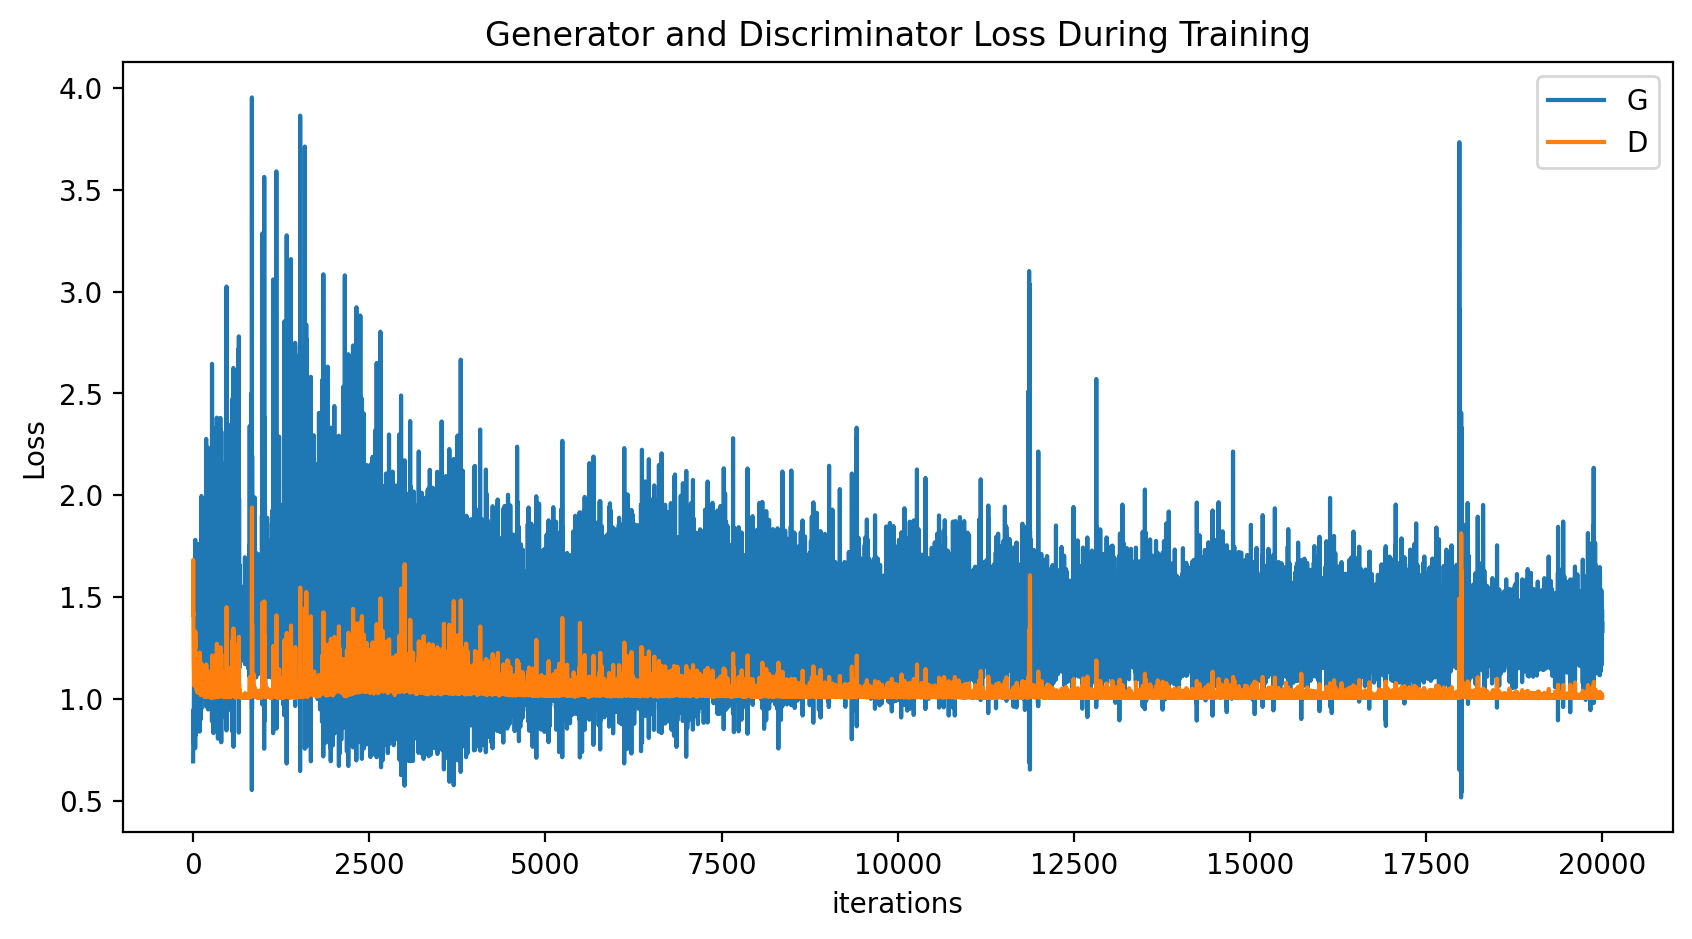

In [49]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.savefig("Output_files/80_gen_loss.png")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

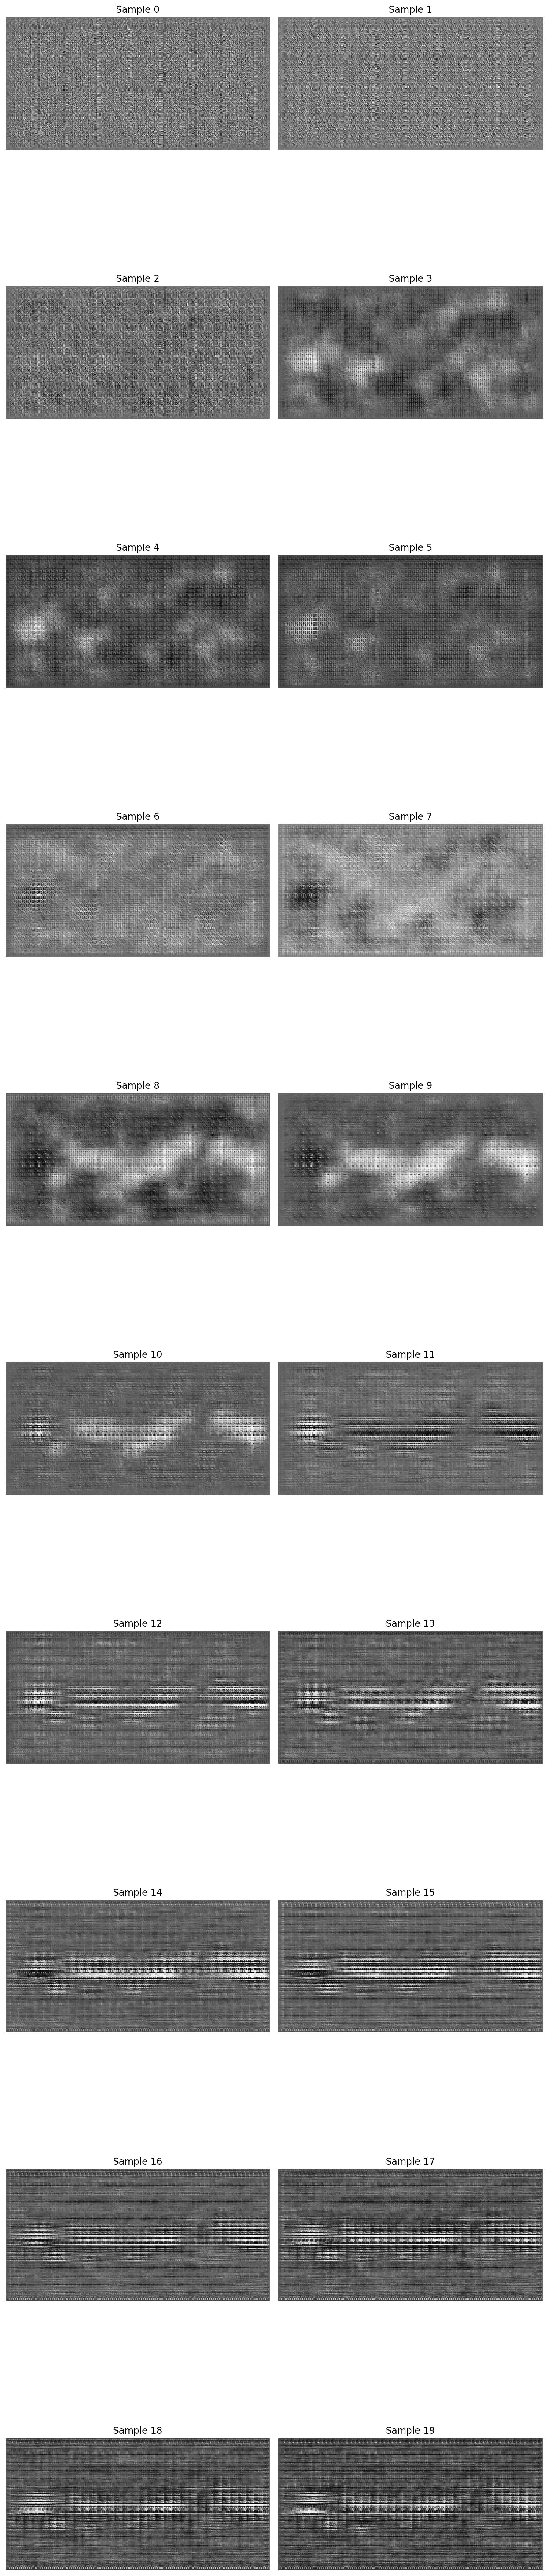

In [50]:
import matplotlib.pyplot as plt

# Set the number of samples to display
num_samples = 20
samples_per_row = 2
num_rows = num_samples // samples_per_row

# Create a figure and subplots
fig, axs = plt.subplots(num_rows, samples_per_row, figsize=(10, num_rows * 5))

# Loop through the samples
for i in range(num_samples):
    
    
    # Visualize the generated sample
    sample = output_list[i][0][0].cpu()  # Remove batch dimension
    
    
    # Determine the current subplot position
    row = i // samples_per_row
    col = i % samples_per_row
    
    # Plot the sample
    axs[row, col].imshow(sample.detach().numpy(), cmap='gray')  # Use cmap='gray' for single-channel images
    axs[row, col].axis('off')  # Turn off axis
    axs[row, col].set_title(f'Sample {i}')  # Optional: add a title

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("Output_files/80_20_training.pdf")
# Show the plot
plt.show()


In [48]:
# Print and save the model's state_dict
print("Model's state_dict:")
for param_tensor in netG.state_dict():
    print(param_tensor, "\t", netG.state_dict()[param_tensor].size())

torch.save(netG.state_dict(), "80_20_gen.pt")

Model's state_dict:
label_emb.weight 	 torch.Size([18, 50])
fc_label.weight 	 torch.Size([128, 50])
fc_label.bias 	 torch.Size([128])
fc_noise.weight 	 torch.Size([16384, 100])
fc_noise.bias 	 torch.Size([16384])
model.0.weight 	 torch.Size([129, 128, 4, 4])
model.0.bias 	 torch.Size([128])
model.1.weight 	 torch.Size([128])
model.1.bias 	 torch.Size([128])
model.1.running_mean 	 torch.Size([128])
model.1.running_var 	 torch.Size([128])
model.1.num_batches_tracked 	 torch.Size([])
model.3.weight 	 torch.Size([128, 64, 4, 4])
model.3.bias 	 torch.Size([64])
model.4.weight 	 torch.Size([64])
model.4.bias 	 torch.Size([64])
model.4.running_mean 	 torch.Size([64])
model.4.running_var 	 torch.Size([64])
model.4.num_batches_tracked 	 torch.Size([])
model.6.weight 	 torch.Size([64, 32, 4, 4])
model.6.bias 	 torch.Size([32])
model.7.weight 	 torch.Size([32])
model.7.bias 	 torch.Size([32])
model.7.running_mean 	 torch.Size([32])
model.7.running_var 	 torch.Size([32])
model.7.num_batches_tracke